In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Our model
import torch.nn as nn
import torchvision.models

class CNN(nn.Module):
    def __init__(self, fc1_out = 128, fc2_out = 32, dropout = 0.3):
        super(CNN, self).__init__()
        # Transfer learning from alexnet
        self.fc1 = nn.Linear(256*6*6, fc1_out)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        self.fc3 = nn.Linear(fc2_out, 15)

    def forward(self, x):
        x = self.dropout(x).detach()
        x = x.view(-1, 256*6*6)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.fc3(x)

In [3]:
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import os
import torchvision
from tqdm import tqdm

alexnet = torchvision.models.alexnet(pretrained=True)

# include original image for demonstration purposes 
class HARDataset(Dataset):
    """
    Custom dataset for HAR images that returns transformed image array and corresponding class
    """
    
    def __init__(self, data, img_dir, transform=None):
        """
        Inputs:
            data (list): 2D list in the form of [[class, file_name]]
            img_dir (String): directory of the folder with all the images
            transform (torchvision.transforms): transformation to be applied to images
        """
        self.data = np.array(data)
        self.img_dir = img_dir
        self.transform = transform
        self.alexnet = alexnet.features.requires_grad_(False)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = os.path.join(self.img_dir, self.data[idx, 1])
        img_class = int(self.data[idx, 0])
        image = plt.imread(image_name)
        if self.transform:
            image = self.transform(np.array(image))
        
        img_one_hot = torch.zeros(15)
        img_one_hot[img_class] = 1
        sample = {'image':  self.alexnet(image), 'img_class': img_one_hot, 'original': image}
        return sample

def test_filename_loader():
    """
    Helper function that loads image file name and corresponding class from 'Human Action Recognition' folder
    """
    test = pd.read_csv('/content/drive/My Drive/Human Action Recognition/Testing_set_1.csv')

    # one-hot encoding not needed for nn.CrossEntropyLoss()(x,y)
    # y is the index for the class (0 to 14) and x is the output from the model without sigmoid (1x15 tensor)
    classes = {
        "sitting":0,
        "using_laptop":1,
        "hugging":2,
        "sleeping":3,
        "drinking":4,
        "clapping":5,
        "dancing":6,
        "cycling":7,
        "calling":8,
        "laughing":9,
        "eating":10,
        "fighting":11,
        "listening_to_music":12,
        "running":13,
        "texting":14,
    }
    images = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[],
        5:[],
        6:[],
        7:[],
        8:[],
        9:[],
        10:[],
        11:[],
        12:[],
        13:[],
        14:[]
    }
    test_images = []

    for _, data in test.iterrows():
        if (data[1] in classes.keys()):
            img_class = classes[data[1]]
            images[img_class].append([img_class, data[0]])
    
    for imgs in images.values():
        test_images += imgs

    return test_images

def test_data_loader(batch_size=64, shuffle=True, num_workers=0):
    """
    Returns DataLoader objects for train and validation data
    """
    test_images = test_filename_loader()

    # normalize the pixel values to between 0 and 1 and crop to same size for DataLoader to work
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.FiveCrop(150), transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])), transforms.Resize((224, 224))])
    #img_dir = os.path.join(os.path.dirname(__file__), 'Human Action Recognition', 'test')
    img_dir = '/content/drive/My Drive/Human Action Recognition/test'

    test_dataset = HARDataset(data=test_images, img_dir=img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return test_loader

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [5]:
net = CNN()
net.load_state_dict(torch.load("/content/drive/My Drive/Human Action Recognition/model/bs128_lr0.0001_epoch17", map_location=torch.device('cpu')))

net.eval()
test_loader = test_data_loader(batch_size=1)

In [6]:
def demonstration(class_name):
  classes = [
      "sitting",
      "using_laptop",
      "hugging",
      "sleeping",
      "drinking",
      "clapping",
      "dancing",
      "cycling",
      "calling",
      "laughing",
      "eating",
      "fighting",
      "listening_to_music",
      "running",
      "texting",
  ]

  i = 0
  for batch in test_loader:
    #if (i == 3): break
    img, label, orig = batch.values()
    truth = np.argmax(label).item()
    if (classes[truth] != class_name):
      continue 

    processed = []
    for k in range(5):
      feature_map = img.squeeze(0)[k]
      gray_scale = torch.sum(feature_map,0)
      gray_scale = gray_scale / feature_map.shape[0]
      processed.append(gray_scale.data.cpu().numpy())
      #print("processed shape", processed[i].shape)

    # Display all 5 cropped images
    fig_orig=plt.figure(figsize=(8, 8))
    rows, cols = 1, 5
    for j in range(0, cols*rows):
      fig_orig.add_subplot(rows, cols, j+1)
      plt.imshow(orig[0][j].permute(1, 2, 0))
      plt.xticks([])
      plt.yticks([])
    plt.show()
    

    # Display all 5 embeddings
    fig_alex=plt.figure(figsize=(8, 8))
    for j in range(0, cols*rows):
      fig_alex.add_subplot(rows, cols, j+1)
      plt.imshow(processed[j])
      plt.xticks([])
      plt.yticks([])
    plt.show()

    # Display prediction and truth 
    softmax = nn.Softmax(dim = 1)
    output = softmax(net(img))
    truth = np.argmax(label).item()
    print(f'truth : {classes[truth]}')
    for p in range(5):
      pred = np.argmax(output.detach()[p]).item()
      print(f'prediction {p}: {classes[pred]}')
    #i += 1


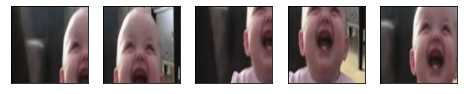

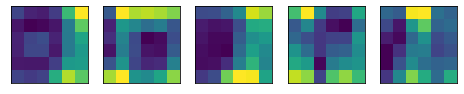

truth : laughing
prediction 0: laughing
prediction 1: laughing
prediction 2: texting
prediction 3: laughing
prediction 4: laughing


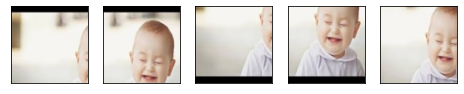

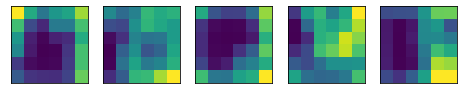

truth : laughing
prediction 0: texting
prediction 1: laughing
prediction 2: sleeping
prediction 3: laughing
prediction 4: laughing


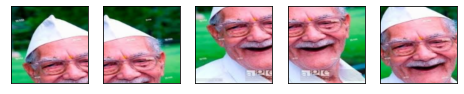

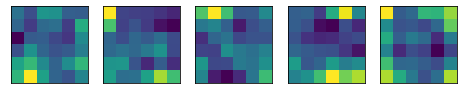

truth : laughing
prediction 0: laughing
prediction 1: laughing
prediction 2: laughing
prediction 3: laughing
prediction 4: laughing


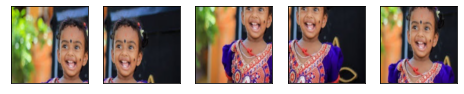

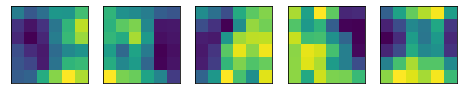

truth : laughing
prediction 0: laughing
prediction 1: laughing
prediction 2: drinking
prediction 3: clapping
prediction 4: laughing


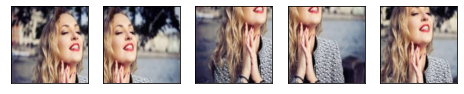

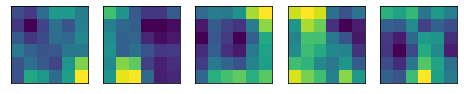

truth : laughing
prediction 0: texting
prediction 1: laughing
prediction 2: laughing
prediction 3: calling
prediction 4: laughing


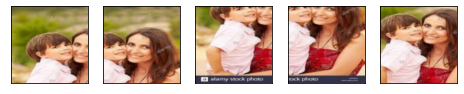

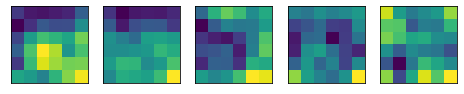

truth : laughing
prediction 0: laughing
prediction 1: laughing
prediction 2: using_laptop
prediction 3: using_laptop
prediction 4: drinking


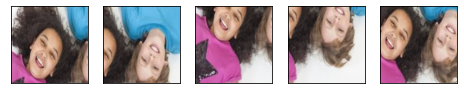

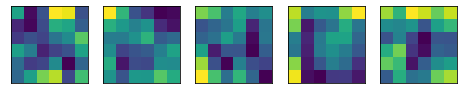

truth : laughing
prediction 0: hugging
prediction 1: laughing
prediction 2: hugging
prediction 3: laughing
prediction 4: laughing


In [7]:
demonstration("laughing")